## Basic Data Exploration 

Plan of action: 
* Load in data
* extract lat/lon and number of mosquitoes and whether WNV present
* Use R code to do geospatial modelling
* Get xgboost code working
* get keras code working
* combine submission

In [1]:
%pylab inline
import os
import seaborn as sns
import pandas as pd
subm_folder = './submissions'
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


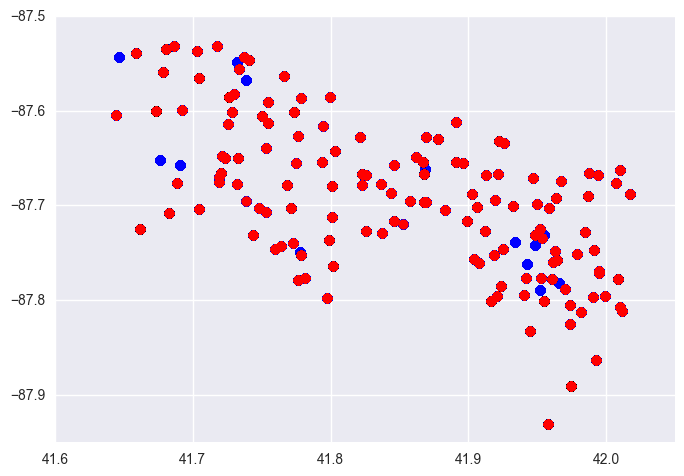

In [4]:
plt.plot(df_test['Latitude'],df_test['Longitude'],'bo');
plt.plot(df_train['Latitude'],df_train['Longitude'],'ro');

Lots of overlap. Let's look at the unique locations.

In [5]:
addresses = df_train.groupby('Address').groups

In [6]:
print('Total locations: {}'.format(len(addresses.keys())))

Total locations: 138


Create some labels via k means clustering

In [7]:
ad_df = df_train.groupby('Address').mean()

X = ad_df[['Latitude','Longitude']].get_values()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
labels = kmeans.labels_

ad_df['label'] = labels

In [8]:
import folium
from folium.plugins import MarkerCluster


latm = df_test['Latitude'].mean()
longm = df_test['Longitude'].mean()
m = folium.Map(location=[latm, longm])
i = 0
for label in labels:
    marker_cluster = MarkerCluster().add_to(m)
    cluster_addresses = ad_df[ad_df['label']==label]
    for index,row in cluster_addresses.iterrows():
        if i < 100: #folium can't seem to cope with too many points, which is annoying.
            
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup='Prob. WNV: {:.2f}, average mosquitoes: {:.2f}'.format(row['WnvPresent'],row['NumMosquitos'])
            ).add_to(marker_cluster)
            i+=1
        

In [9]:
m

## Leaky feature exploration

There's an issue with how the data is aggregated. The more readings there are on the same date, the more likely WNV is present. Let's explore this.

In [10]:
def plotGroupedBy(col):
    wnv_present = df_train.groupby([col]).sum()['WnvPresent']>0
    present_counts = df_train.groupby([col]).count()['WnvPresent'][wnv_present].get_values()
    npresent_counts = df_train.groupby([col]).count()['WnvPresent'][-wnv_present].get_values()
    plt.hist([present_counts,npresent_counts], 50, stacked=True,label=['present','not present'])
    plt.legend();

## Plot of address counts where Wnv present versus where it isn't

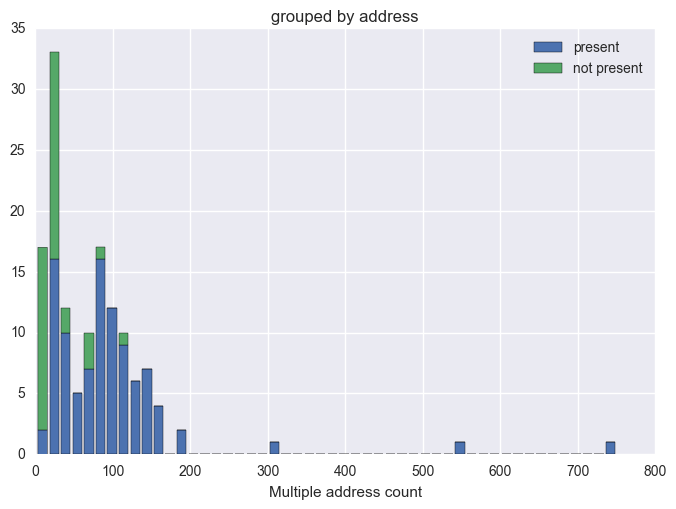

In [11]:
plotGroupedBy('Address');
plt.title('grouped by address');
plt.xlabel('Multiple address count');

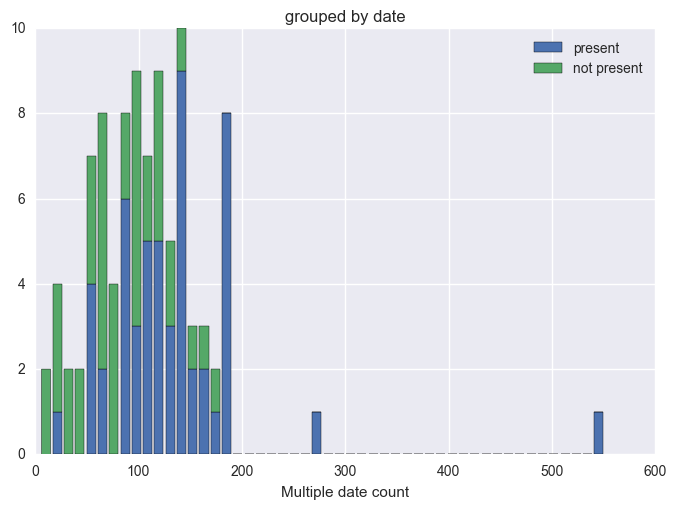

In [12]:
plotGroupedBy('Date');
plt.title('grouped by date');
plt.xlabel('Multiple date count');

### Mean Wnv compared to total count

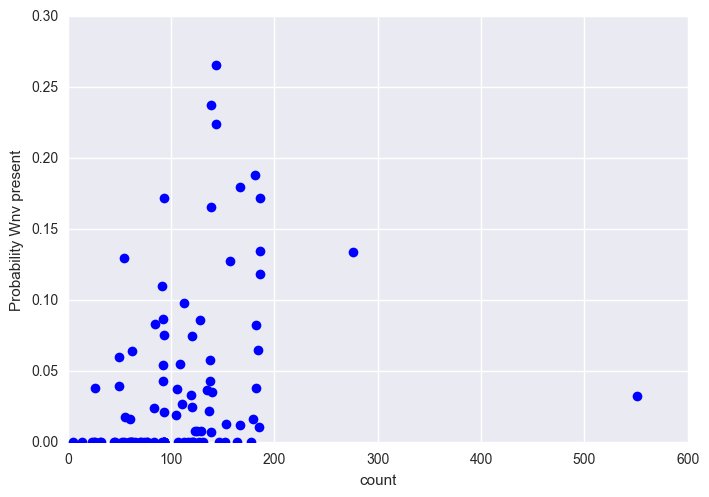

In [14]:
x = df_train.groupby(['Date']).count()['WnvPresent']
y = df_train.groupby(['Date']).mean()['WnvPresent']
plt.plot(x,y,'bo');
plt.xlabel('count');
plt.ylabel('Probability Wnv present');

# Exploit Leaky feature

In [63]:
# DateCount
dt_count = df_test.groupby('Date').count()[['Id']] #get mutiple counts on a certain date
dt_count.columns = ['DateCount'] #create new column for how many times date repeated.
test = pd.merge(df_test, dt_count, how='inner', left_on='Date', right_index=True)
cnt_pred = np.array(test['DateCount'])
cnt_pred = 1.0*(cnt_pred - cnt_pred.min()) / (cnt_pred.max() - cnt_pred.min()) #normalize value to get prob.

#prepare submission
ss = pd.DataFrame(columns=['Id','WnvPresent'])
ss['WnvPresent'] = cnt_pred
ss['Id'] = test.index + 1
ss.to_csv(os.path.join(subm_folder, 'DateCount.csv'), index=False)

scores 0.75071, which would have put me in 529th place

# Import Weather

In [142]:
df_weather= pd.read_csv('./data/weather.csv')

In [146]:
df_weather.columns

Index([u'Station', u'Date', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint',
       u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum',
       u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure',
       u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
      dtype='object')

# Explore Mosquito species

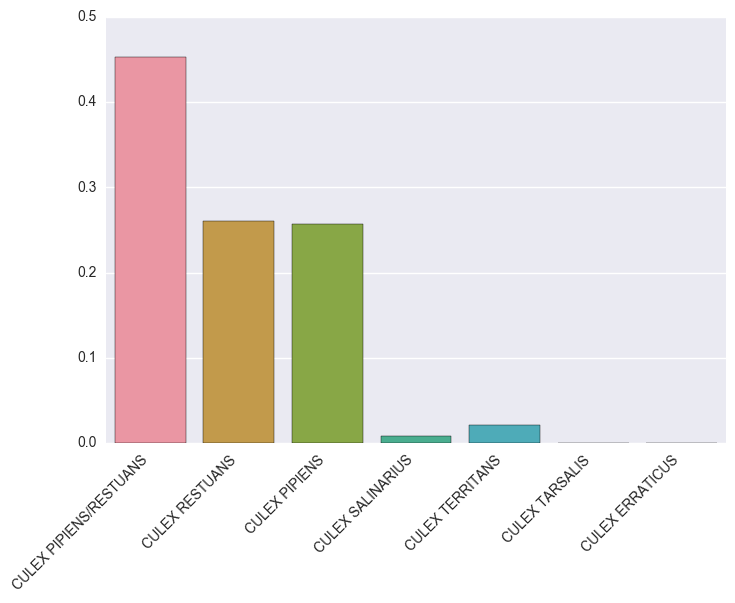

In [15]:
labels = []
counts = []
for spec in df_train[u'Species'].unique():
    labels.append(spec)
    counts.append((df_train['Species']==spec).mean())
    
sns.barplot(x=labels,y=counts);
plt.xticks(rotation=45,ha='right');

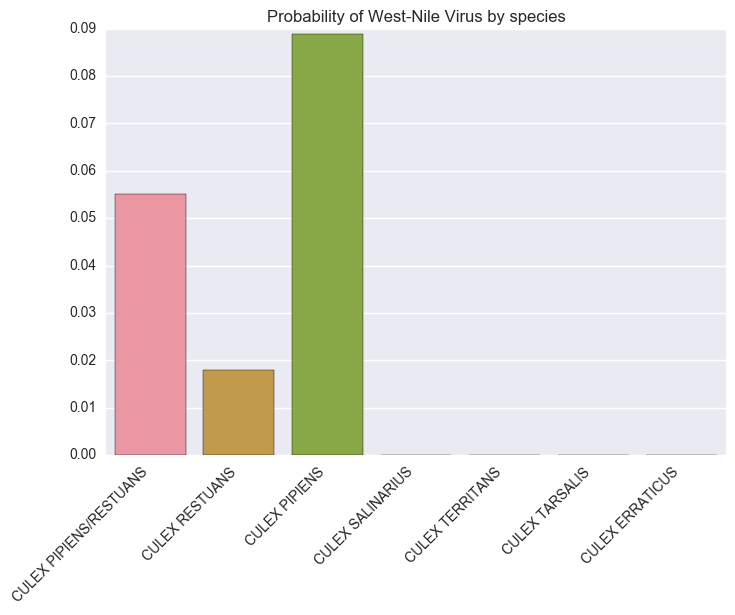

In [16]:
labels = []
counts = []
for spec in df_train[u'Species'].unique():
    labels.append(spec)
    
    sr = (df_train['Species']==spec)
    
    counts.append(df_train[sr]['WnvPresent'].mean())
    
sns.barplot(x=labels,y=counts);
plt.xticks(rotation=45,ha='right');
plt.title('Probability of West-Nile Virus by species');

## Look at how mosquitos are distributed in traps

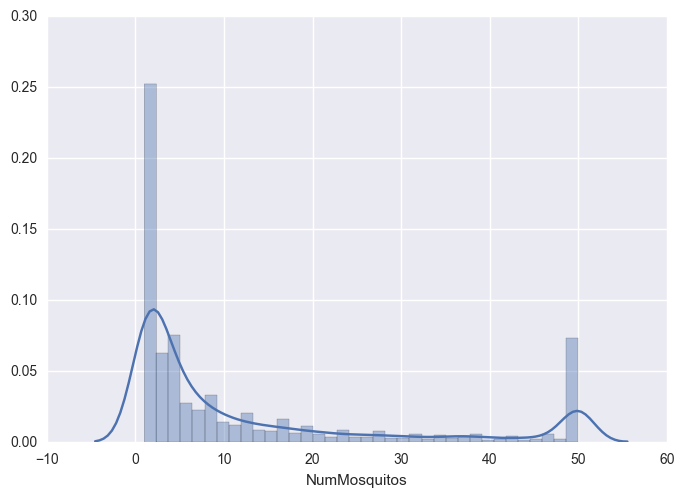

In [18]:
sns.distplot(df_train['NumMosquitos']);

Data is capped at 50. Really, we should sum by trap in order to get the true distribution of mosquitos

In [20]:
df = df_train.copy()

In [28]:
mosCount = df.groupby(['Trap','Date']).sum()['NumMosquitos'].get_values()

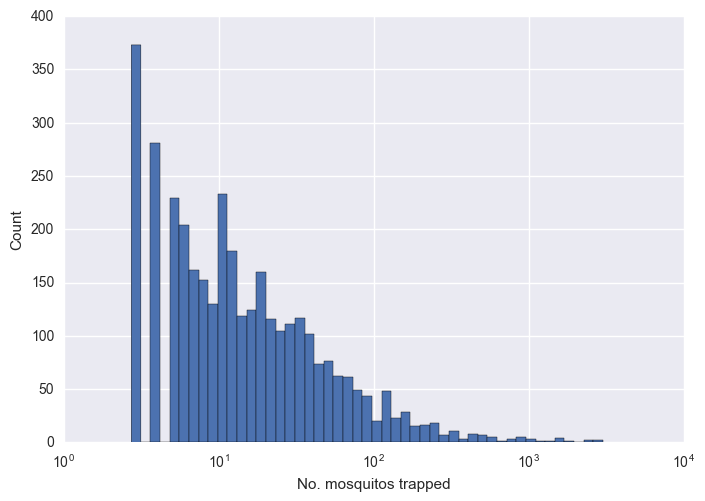

In [36]:
bins = np.linspace(1.,np.max(np.log(mosCount)));
bins = np.exp(bins)
plt.hist(mosCount,bins=bins);
plt.xscale('log');plt.xlabel('No. mosquitos trapped');
plt.ylabel('Count');

## Investigate Spray data

In [42]:
df_spray = pd.read_csv('./data/spray.csv')

In [43]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


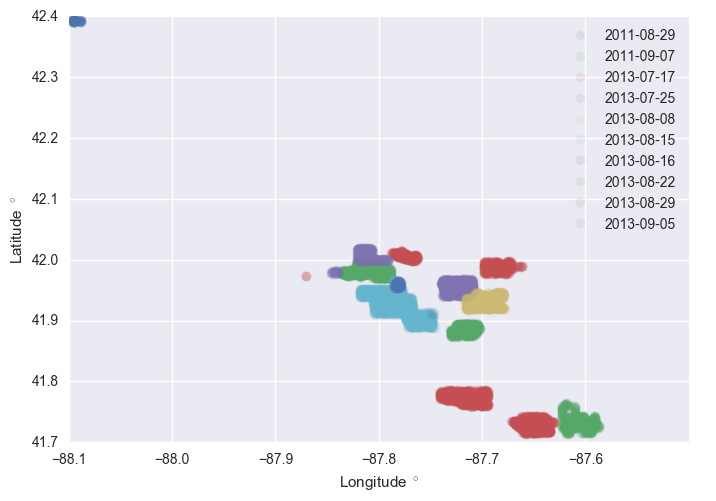

In [49]:
for date in df_spray['Date'].unique():
    dates = df_spray['Date'] == date
    plt.plot(df_spray[dates]['Longitude'],df_spray[dates]['Latitude'],'o',alpha=0.1,label=date);
plt.legend();
plt.xlabel('Longitude $^\circ$');
plt.ylabel('Latitude $^\circ$');

In [48]:
value = df_spray['Latitude'][0]
df_train.ix[(df_train['Latitude']-value).abs().argsort()[:2]]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
6455,2011-07-11,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX RESTUANS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.01743,-87.687769,8,23,0
5076,2009-07-31,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS/RESTUANS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.01743,-87.687769,8,3,0
